# Economics of Cyber Security

In [104]:
import pandas as pd
import matplotlib.pyplot as plt

## Recent test

### Cleaning

In [101]:
test_df = pd.read_csv("recent_tests.csv", sep=';')

test_df.astype({'Session': 'str',
                'Timestamp': 'str',
                'Client IP Block': 'str',
                'ASN': 'str', 
                'Country': 'str', 
                'NAT': 'str', 
                'Outbound Private Status': 'str',
               'Adjacent Spoof Prefix Length': 'str'}).dtypes

df_blocked = test_df.loc[test_df['Outbound Routable Status'] == 'blocked']
df_received = test_df.loc[test_df['Outbound Routable Status'] == 'received']

### Statical functions

In [169]:
def table_states(curr_df):
    
    print("Total number of rows in table: %s" %curr_df.shape[0])

    print("Number of unique counties:  %s" %curr_df['Country'].nunique())
    print("Number of unique ASN:  %s" %curr_df['ASN'].nunique())
    
    NAT = curr_df.loc[curr_df['NAT'] == 'yes']
    NAT_percentage = round((NAT.shape[0] / curr_df.shape[0]) * 100.0, 2)
    print("Percentage using NAT: %s%%" %NAT_percentage)

### Visuals helper function

In [182]:
def NAT_count(df, val):
    NAT_temp = df.loc[df['NAT'] == val]
    
    return NAT_temp.shape[0]
    
def plot_stats(df, column, title, threshold, NAT = False):
    fig = plt.figure(figsize=(22, 8))
    ax = fig.add_axes([0,0,1,1])
    
    columns = df[column].unique()
    counts = []
    included = []
    excluded = []
        
    if not NAT:
        for col in columns:
            temp_df = df.loc[df[column] == col]
            
            if temp_df.shape[0] > threshold:
                counts.append(temp_df.shape[0])
                included.append(col)
            else:
                excluded.append(col)
            
        ax.bar(columns, counts)
    
    else:
        NAT_pos_count = []
        NAT_neg_count = []
        
        for col in columns:
            temp_df = df.loc[df[column] == col]
            
            if temp_df.shape[0] > threshold:
                NAT_pos_count.append(NAT_count(temp_df, 'yes'))
                NAT_neg_count.append(NAT_count(temp_df, 'no'))
                included.append(col)
            else:
                excluded.append(col)
            
        ax.bar(included, NAT_pos_count)
        ax.bar(included, NAT_neg_count)
        ax.legend(labels=['NAT present', 'NAT not present'])
        
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.set_title(title)
    plt.xticks(rotation=90)
    plt.show()
    
    if len(excluded) > 0:
        print("Excluded using threshold %s: %s" % (threshold, excluded))
    else:
        print("All values are depicted")

### Complete set analysis

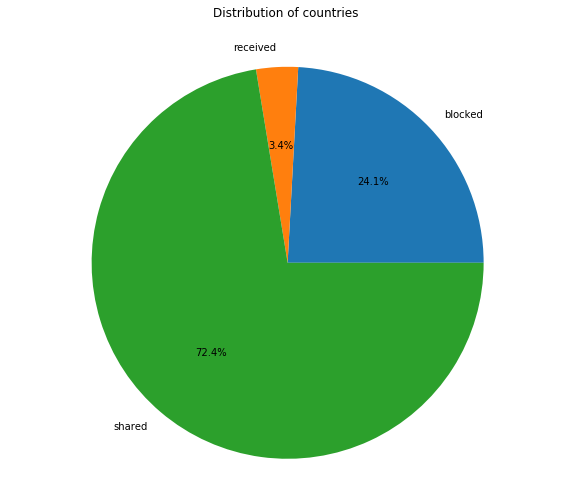

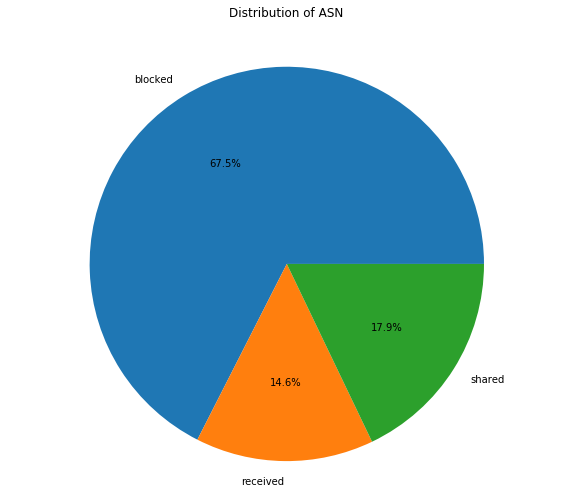

In [198]:
def check_cases(df_block, df_receive, column, title):
    unique_blocked = df_block[column].unique()
    unique_received = df_received[column].unique()
    
    shared = [x for x in unique_blocked if x in unique_received]
    blocked = [x for x in unique_blocked if x not in shared]
    received = [x for x in unique_received if x not in shared]
    
    labels = 'blocked', 'received', 'shared'
    total = len(shared) + len(blocked) + len(received)
    
    sizes = [len(blocked)/total, len(received)/total, len(shared)/total]
    
    fig1, ax1 = plt.subplots(figsize=(10,8))
    
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
    ax1.axis('equal')
    ax1.set_title(title, pad = 30)
    
    plt.show()

check_cases(df_blocked, df_received, "Country", "Distribution of countries")
check_cases(df_blocked, df_received, "ASN", "Distribution of ASN")

### Blocked information

In [165]:
table_states(df_blocked)

Total number of rows in table: 38539
Number of unique counties:  112
Number of unique ASN:  1251
Percentage using NAT: 61.43%


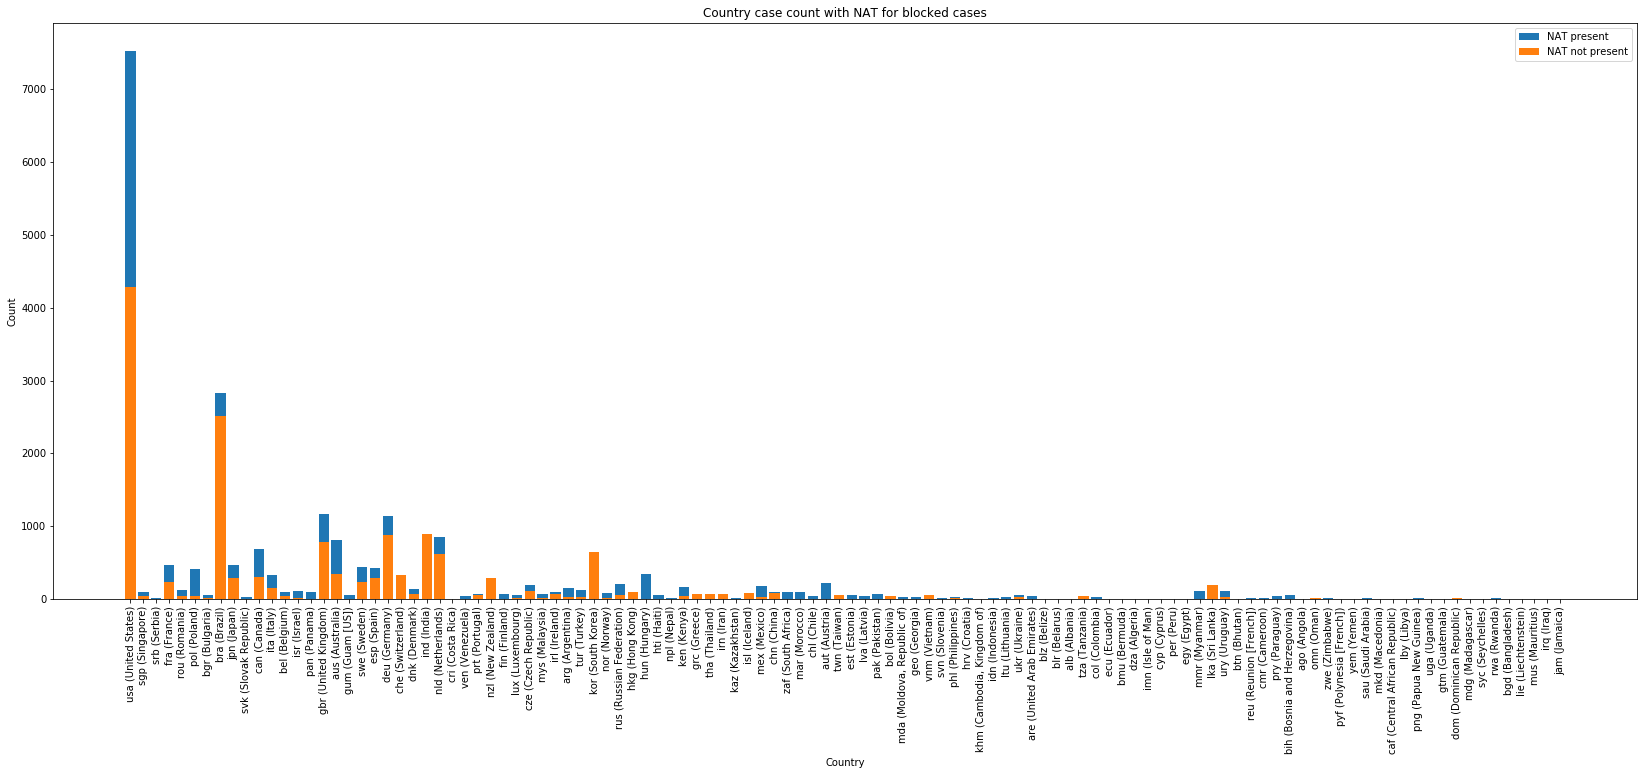

All values are depicted


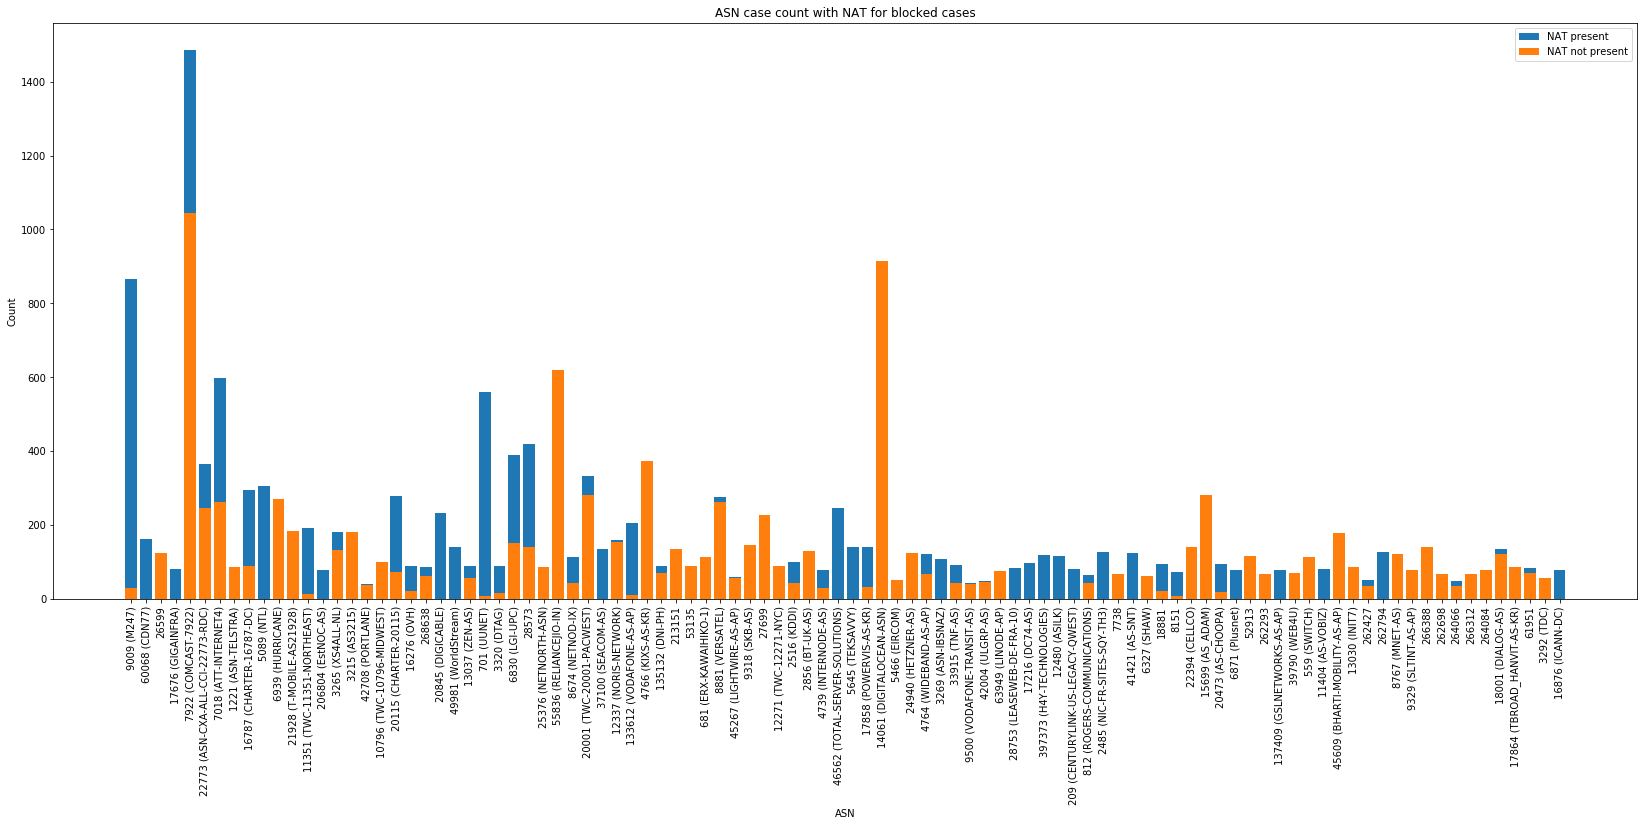

Excluded using threshold 75: ['396190 (LEASEWEB-USA-SEA-10)', '133752 (LEASEWEB-APAC-HKG-10)', '29854 (WESTHOST)', '49367 (ASSEFLOW)', '8075 (MICROSOFT-CORP-MSN-AS-BLOCK)', '35758 (HQserv_communication_solutions)', '8100 (ASN-QUADRANET-GLOBAL)', '262977', '264478', '5650 (FRONTIER-FRTR)', '11556', '21472 (SERVERHOUSE)', '26615', '17456 (PDSGUAM-USTRANSPORT-AS-GU-AP)', '3301 (TELIANET-SWEDEN)', '46690 (SNET-FCC)', '38 (UIUC)', '29680 (VOZTELECOM)', '852 (ASN852)', '40029 (NOVUS-3)', '20 (UR)', '197405 (TOMKOW-AS)', '20694 (NMMN-AS)', '15576 (NTS)', '10745 (ARIN-ASH-CHA)', '27 (UMDNET)', '174 (COGENT-174)', '42831 (UKSERVERS-AS)', '20712 (AS20712)', '12876 (AS12876)', '63023 (AS-GLOBALTELEHOST)', '51852 (PLI-AS)', '132335 (NETWORK-LEAPSWITCH-IN)', '29889 (FSNET-1)', '34888 (SIMPLECARRER2)', '52423', '262287', '60458 (ASN-XTUDIONET)', '20860 (IOMART-AS)', '24768 (ALMOUROLTEC)', '136557 (HOST-AS-AP)', '51765 (CREANOVA-AS)', '9008 (ASN-VO)', '47317 (WEB4CE)', '55720 (GIGABIT-MY)', '24961 (M

In [167]:
plot_stats(df_blocked, "Country", 'Country case count with NAT for blocked cases', 0, True)
plot_stats(df_blocked, "ASN", 'ASN case count with NAT for blocked cases', 75, True)

### Received information

In [171]:
table_states(df_received)

Total number of rows in table: 5838
Number of unique counties:  88
Number of unique ASN:  476
Percentage using NAT: 59.82%


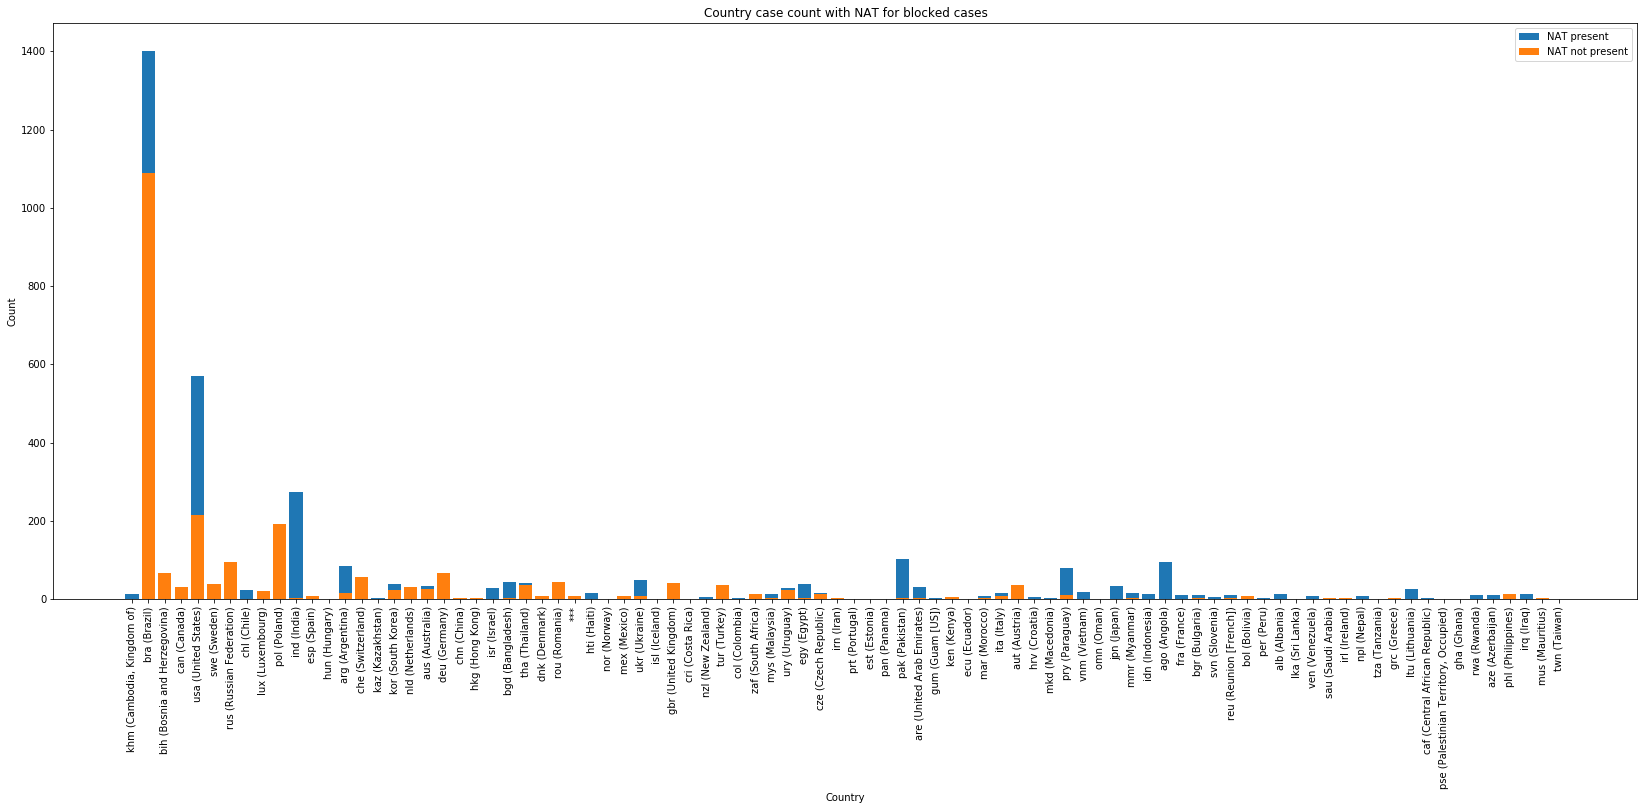

All values are depicted


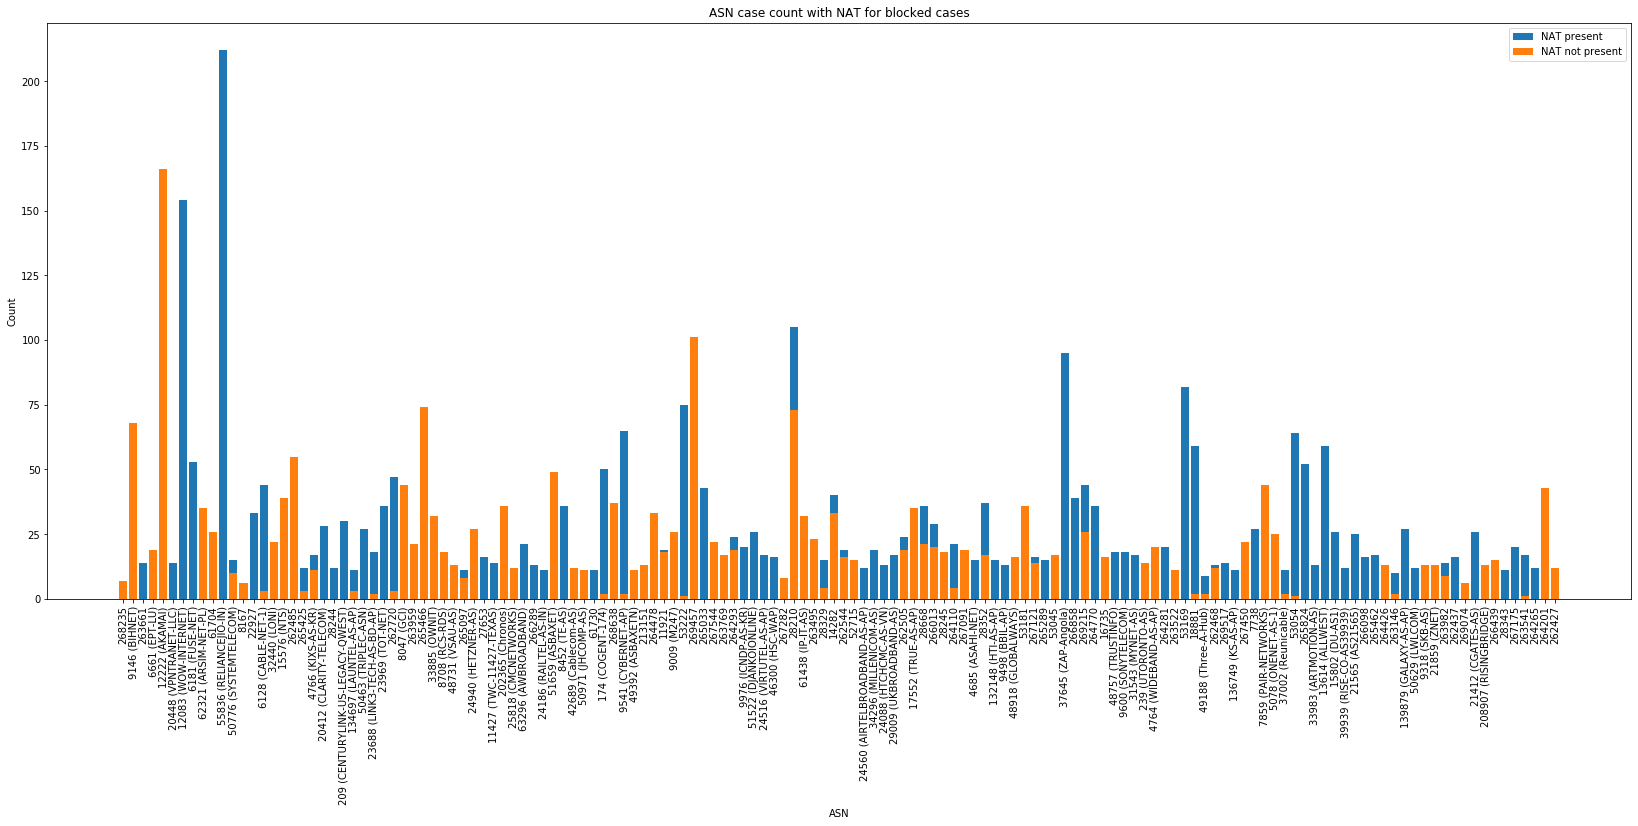

Excluded using threshold 10: ['138528 (EMPIRETECH-AS-AP)', '262977', '28238', '7040 (NETMINDERS)', '61317 (ASDETUK)', '27257 (WEBAIR-INTERNET)', '42708 (PORTLANE)', '42994 (HQserv_Communication_Solutions)', '270553', '135180 (STARLING-AS-IN)', '29680 (VOZTELECOM)', '43529 (VIDANET-AS)', '264582', '52861', '9198 (KAZTELECOM-AS)', '28235', '264353', '45184 (DEN-ISP-AS-IN-AP)', '263073', '41436 (CloudWebManage-EU)', '134026 (ULTRANET-AS)', '52771', '11650 (PLDI)', '40676 (AS40676)', '262389', '264169', '137571 (PESYUN-AS-AP)', '197288 (STOFANET)', '39642 (DK-ESS-AS)', '63528 (BKNIX-AS-AP)', '38901 (EZECOM-AS-AP)', '398357', '48347 (MTW-AS)', '60068 (CDN77)', '45671 (AS45671-NET-AU)', '136258 (ONEPROVIDER-AS)', '398019 (DYNU)', '139235 (TSRDC-AS-AP)', '42331 (FREEHOST)', '11051 (CYBERVERSE)', '50613 (ThorDC-AS)', '49485 (HA-SDC)', '3790', '136557 (HOST-AS-AP)', '210329 (CloudWebManage-UK-1)', '52510', '19429', '20473 (AS-CHOOPA)', '132976 (KINGSBROADBAND-AS-IN)', '45382 (EHOSTIDC-AS-KR)', 

In [183]:
plot_stats(df_received, "Country", 'Country case count with NAT for blocked cases', 0, True)
plot_stats(df_received, "ASN", 'ASN case count with NAT for blocked cases', 10, True)